In [62]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from dateutil import parser
import missingno as msno
import re
from scipy.stats import mode

In [2]:
pd.set_option("display.max_column",500)
pd.set_option("display.max_rows",500)
sns.set(style="darkgrid")
sns.set_context("talk")

In [3]:
#load data
data=pd.read_csv("loan.csv",low_memory=False)

In [4]:
#Function to create meta data of the data
def create_Meta(data):
    meta_data={'dtypes':data.dtypes,
              'missing_values':round(data.isna().sum()*100/data.shape[0],3),
              'count':[data[i].count() for i in data.columns.values],
              'Number_Uniques':[data[i].nunique() for i in data.columns.values]}
    return pd.DataFrame(meta_data)

In [5]:
Meta_Data=create_Meta(data)

In [6]:
#Display meta data of our data
Meta_Data.T

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
dtypes,int64,int64,int64,int64,float64,object,object,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,float64,int64,object,int64,float64,float64,int64,int64,int64,object,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object,object,float64,float64,int64,object,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
missing_values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.191,2.707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.581,0.0,0.028,0.0,0.0,0.0,0.0,0.0,0.0,64.662,92.985,0.0,0.0,0.0,0.126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179,0.0,97.13,0.005,0.141,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.141,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.755,0.098,100.0,100.0,100.0,100.0
count,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,37258,38642,39717,39717,39717,39717,39717,39717,39717,26777,39717,39706,39717,39717,39717,39717,39717,39717,14035,2786,39717,39717,39717,39667,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,39646,39717,1140,39715,39661,0,39717,39717,0,0,0,39717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39661,39717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39020,39678,0,0,0,0
Number_Uniques,39717,39717,885,1041,8205,2,371,15383,7,35,28820,11,5,5318,3,55,3,1,39717,26527,14,19615,823,50,2868,11,526,9,95,111,40,5,21711,1089,82,1,1137,1138,37850,37518,7976,35148,1356,4040,2616,101,34930,2,106,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0


In [7]:
#Sorting Meta Data on the basis of missing value percentage in descending order
Meta_Data=Meta_Data.sort_values(by='missing_values',ascending=False)

In [8]:
#Slicing Meta Data on basis of missing value percentage which shall be greater than 30%
Meta_Data[Meta_Data['missing_values']>30]

,dtypes,missing_values,count,Number_Uniques
verification_status_joint,float64,100.000,0,0
annual_inc_joint,float64,100.000,0,0
mo_sin_old_rev_tl_op,float64,100.000,0,0
mo_sin_old_il_acct,float64,100.000,0,0
bc_util,float64,100.000,0,0
bc_open_to_buy,float64,100.000,0,0
avg_cur_bal,float64,100.000,0,0
acc_open_past_24mths,float64,100.000,0,0
inq_last_12m,float64,100.000,0,0
total_cu_tl,float64,100.000,0,0


In [9]:
#We have noticed that there are many columns which have more than 90 percent missing values
# There are columns which have 30% and 64% missing values also . 
#We will drop columns having missing values more than 50% and for rest we will explore and then take a call
missing_value_columns=Meta_Data[Meta_Data['missing_values']>50].index

In [10]:
#Dropped missing value columns
ft_data=data.drop(missing_value_columns,axis=1)

In [11]:
#Shape after and before dropping missing value columns
#We notice that 50% approx columns have been dropped
ft_data.shape,data.shape

((39717, 54), (39717, 111))

In [12]:
ft_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


In [13]:
def find_pattern(x):
    r=r"[0-9]"
    start,end=re.search(r,x).span()
    x=x[start:end+1]
    return x

In [14]:
indx=ft_data[ft_data["emp_length"].notnull()]['emp_length'].index.values.tolist()
ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].map(find_pattern)

In [15]:
#data cleaning
def data_split(a,x,y):
    b=a.split(x)[y]
    return b

ft_data['term']=ft_data.term.apply(data_split,args=(" ",1))


In [16]:
ft_data["int_rate"]=ft_data.int_rate.apply(data_split,args=("%",0))

In [17]:

# ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].apply(data_split,args=("+",0))
indx=ft_data[ft_data["revol_util"].notnull()]['revol_util'].index.values.tolist()
ft_data['revol_util'].loc[indx,]=ft_data['revol_util'].loc[indx,].apply(data_split,args=("%",0))

In [18]:
#Checking if missing data is not at Random
#Creating dichotomous column for missing variable,1->missing,0->not missing
ft_data['desc_isMissing']=np.where(ft_data['desc'].isna(),1,0)
ft_data['emp_title_isMissing']=np.where(ft_data['emp_title'].isna(),1,0)
ft_data['emp_length_isMissing']=np.where(ft_data['emp_length'].isna(),1,0)

In [19]:
ft_data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

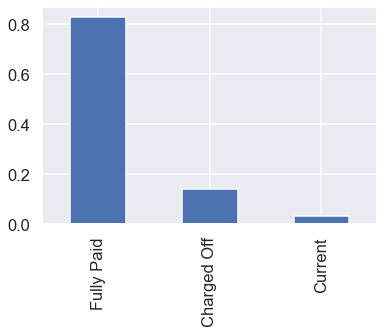

In [20]:
#We find that 80% of description of loan provided by borrower is missing for those who have fully paid 
ft_data[ft_data.desc_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

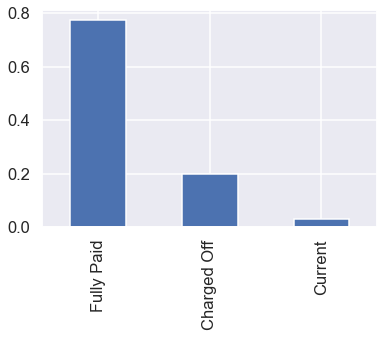

In [21]:
#We find that 80% of job title provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_title_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

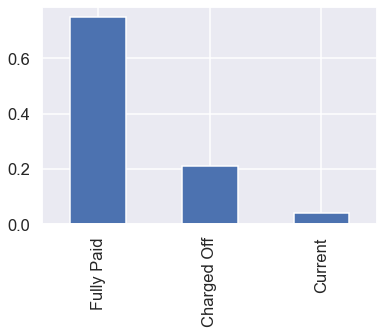

In [22]:
#We find that 70% of job tenure provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_length_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

It has been seen that majority of the missing data are of those who have fully paid, that is those who are likely to fully pay the loan amount. Hence we can say that the missing data is not at random. There is a clear pattern which we can see

In [23]:
descMissing_data=ft_data[ft_data.desc_isMissing==1]

In [24]:
descMissing_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,desc_isMissing,emp_title_isMissing,emp_length_isMissing
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,2,0,2956,98.50,10,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.0,0.0000,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,1,0
5,1075269,1311441,5000,5000,5000.0,36,7.90,156.46,A,A4,Veolia Transportaton,3,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,Nov-04,3,9,0,7963,28.30,12,f,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.0,0.0,0.0000,Jan-15,161.03,Jan-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
11,1069908,1305008,12000,12000,12000.0,36,12.69,402.54,B,B5,UCLA,10,OWN,75000.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Consolidation,913xx,CA,10.78,0,Oct-89,0,12,0,23336,67.10,34,f,0.0,0.0,13947.989160,13947.99,12000.00,1947.99,0.0,0.0,0.0000,Sep-13,6315.30,Aug-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
14,1069057,1303503,10000,10000,10000.0,36,10.65,325.74,B,B2,SFMTA,3,RENT,100000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,Other Loan,951xx,CA,7.06,0,May-91,2,14,0,11997,55.50,29,f,0.0,0.0,7471.990000,7471.99,5433.47,1393.42,0.0,645.1,6.3145,Oct-13,325.74,Mar-14,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
15,1069759,1304871,1000,1000,1000.0,36,16.29,35.31,D,D1,Internal revenue Service,1,RENT,28000.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt Consolidation Loan,641xx,MO,20.31,0,Sep-07,1,11,0,6524,81.50,23,f,0.0,0.0,1270.716942,1270.72,1000.00,270.72,0.0,0.0,0.0000,Jan-15,36.32,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0


In [25]:
print(descMissing_data.loan_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['loan_amnt'].mean(),ft_data['loan_amnt'].mean())

10585.99884080371 11525.55644769765 11219.443814991062


In [26]:
print(descMissing_data.funded_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['funded_amnt'].mean(),ft_data['funded_amnt'].mean())

10373.154945904173 11225.368786645255 10947.713195860715


In [27]:
descMissing_data.term.value_counts()

36    9248
60    3692
Name: term, dtype: int64

In [28]:
ft_data[ft_data.desc_isMissing==0]['term'].value_counts()

36    19848
60     6929
Name: term, dtype: int64

We see that distribution of term on the basis of description missing and not missing are similar that is loan applicants prefference for 3 years is twice more than of 5 years

In [29]:
ft_data.int_rate=ft_data.int_rate.astype('float64')
descMissing_data.int_rate=descMissing_data.int_rate.astype('float64')
print(descMissing_data.int_rate.mean(),ft_data[ft_data.desc_isMissing==0].int_rate.mean(),ft_data.int_rate.mean())

11.995565687789716 12.033553049259668 12.02117657426169


In [30]:
ft_data.emp_length=ft_data.emp_length.astype('float64')
descMissing_data.emp_length=descMissing_data.emp_length.astype('float64')
print(descMissing_data.emp_length.mean(),ft_data[ft_data.desc_isMissing==0].emp_length.mean(),ft_data.emp_length.mean())

5.37983193277311 4.95452633189276 5.092050100926453


In [31]:
ft_data.revol_util=ft_data.revol_util.astype('float64')
descMissing_data.revol_util=descMissing_data.revol_util.astype('float64')
print(descMissing_data.revol_util.mean(),ft_data[ft_data.desc_isMissing==0].revol_util.mean(),ft_data.revol_util.mean())

49.29169606932862 48.610070298770054 48.83215241888721


No clear pattern in interest rate, revol util and employee length seen for missing description and non missing data 

In [32]:
#Try Finding Employee Length based on Title and imputing the missings
title_wise_empLen=ft_data.groupby('emp_title',as_index=False,dropna=True)['emp_length'].median()

In [33]:
emp_title_NA_Length=ft_data[(~ft_data.emp_title.isna())&(ft_data.emp_length.isna())]['emp_title'].values.tolist()

In [34]:
a=pd.DataFrame()
for i in emp_title_NA_Length:
    a=pd.concat([a,title_wise_empLen[title_wise_empLen.emp_title==i]],axis=0)

In [35]:
emp_title=a[~a.emp_length.isna()].emp_title.tolist()

In [36]:
indexes=[]
for i in emp_title:
    ind=ft_data[(ft_data.emp_title==i)&(ft_data.emp_length.isna())]['emp_length'].index.values[0]
    indexes.append(ind)

In [37]:
indexes

[5936, 6631, 7661, 19179, 20772, 22816, 25010, 25322, 26181, 29984, 31126]

In [38]:
missing_emp_length_data=ft_data.loc[indexes,:]
emp_lnt=a[~a.emp_length.isna()].emp_length.tolist()    
missing_emp_length_data.loc[:,'emp_length']=emp_lnt


In [39]:
ft_data=pd.concat([ft_data.drop(indexes,axis=0),missing_emp_length_data],axis=0)

In [40]:
ft_data.reset_index(drop=True,inplace=True)

In [41]:
indexes=ft_data[(ft_data.emp_length.isna())].index.values.tolist()

In [42]:
len(indexes)

1064

In [43]:
#Dropping rows where emp_length is NA
ft_data.drop(indexes,axis=0,inplace=True)

In [44]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      3.725455
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [74]:
#Grouping employee title most frequent based on employee experience
#Treating Missing Values of Employee title
empTitle_by_Length=ft_data.groupby("emp_length",as_index=False).agg({"emp_title":mode})
for i in range(len(empTitle_by_Length)):
    empTitle_by_Length.emp_title[i]=empTitle_by_Length.emp_title[i].mode[0]

In [76]:
empTitle_by_Length

,emp_length,emp_title
0,1.0,Bank of America
1,2.0,Bank of America
2,3.0,Kaiser Permanente
3,4.0,Self Employed
4,5.0,Bank of America
5,6.0,US Army
6,7.0,US Army
7,8.0,US Army
8,9.0,Bank of America
9,9.5,Honeywell


In [78]:
indexes=ft_data[ft_data.emp_title.isna()].index.values.tolist()
empTitle_NAdata=ft_data.loc[indexes,:]
empTitle_NAdata[(empTitle_NAdata.emp_length==1.0)&(empTitle_NAdata.emp_title.isna())]["emp_title"].replace(np.nan,"Bank of America",inplace=True)

In [90]:
empTitle_NAdata.emp_length.value_counts().sum()

1440

In [87]:
#Imputation of missing values in employee title based on employee length
a=pd.DataFrame()
for i in empTitle_NAdata.emp_length.unique().tolist():
    dummy=empTitle_NAdata[(empTitle_NAdata.emp_length==i)&(empTitle_NAdata.emp_title.isna())]
    dummy.emp_title.replace(np.nan,empTitle_by_Length[empTitle_by_Length.emp_length==i].emp_title.values[0],inplace=True)
    a=pd.concat([dummy,a],axis=0)
    
ft_data=pd.concat([ft_data.drop(indexes,axis=0),a],axis=0)

In [95]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      0.000000
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [98]:
ft_data['pub_rec_bankruptcies'].value_counts(dropna=False)

0.0    36386
1.0     1563
NaN      697
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [110]:
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_status':np.count_nonzero})

,loan_status
pub_rec_bankruptcies,
0.0,36386
1.0,1563
2.0,7
NaN,697


In [109]:
#We notice the 697 missing public record of bankcruptcies are not the ones which are either charged off or who have fully paid..
#They belong to Current loan applicants
#Either this NaN can be another category itself or they belong to one specific category
ft_data[ft_data['pub_rec_bankruptcies'].isna()].groupby("loan_status",dropna=False)["pub_rec_bankruptcies"].count()

loan_status
Charged Off    0
Fully Paid     0
Name: pub_rec_bankruptcies, dtype: int64

In [114]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount
#We see that those who have frequently shown bankcruptcies are the ones who have applied for high loan amounts. 
#The missing 697 are the ones which have applied for least loan amount
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_amnt':'mean'})

,loan_amnt
pub_rec_bankruptcies,
0.0,11367.429094
1.0,10094.369802
2.0,12800.000000
NaN,9956.420373


In [116]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are the ones who have applied for the least amount and those who are current have the highest loan amount.
#For NAN category those whose loan is being charged off has the highest loan amount 
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'mean'})

loan_amnt
pub_rec_bankruptcies loan_status              
0.0                  Charged Off  12274.934290
                     Current      17307.260338
                     Fully Paid   11011.605379
1.0                  Charged Off  11677.388060
                     Current      13053.030303
                     Fully Paid    9568.891213
2.0                  Charged Off  12500.000000
                     Current      25000.000000
                     Fully Paid    4866.666667
NaN                  Charged Off  12590.042373
                     Fully Paid    9419.689119

In [117]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are in majority numbers and the current applicants are the least
#Of NaNs i.e 697 applicants 83% are already paid off and only 17% have been charged of
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'count'})

loan_amnt
pub_rec_bankruptcies loan_status           
0.0                  Charged Off       4946
                     Current           1064
                     Fully Paid       30376
1.0                  Charged Off        335
                     Current             33
                     Fully Paid        1195
2.0                  Charged Off          2
                     Current              2
                     Fully Paid           3
NaN                  Charged Off        118
                     Fully Paid         579

0.830703012912482

In [115]:
#Understanding the behavior of bunkcruptcies on basis of average interest rate
#We see that as the number of bankruptcies increases, it increases when the average interest rate rises. 
#The missing 697 have the least interest rate @11% approximately
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'int_rate':'mean'})

,int_rate
pub_rec_bankruptcies,
0.0,12.014279
1.0,13.539264
2.0,15.971429
NaN,10.640230


In [111]:
nan_bankruptcies_records=ft_data[ft_data['pub_rec_bankruptcies'].isna()]

In [135]:
ft_data.groupby(["pub_rec_bankruptcies","emp_title"],dropna=False).agg({"emp_length":"value_counts"})

emp_length
pub_rec_bankruptcies emp_title                         emp_length            
0.0                    old palm inc                    5.0                  1
                      Brocade Communications           7.0                  1
                      CenturyLink                      4.0                  1
                      Department of Homeland Security  4.0                  1
                      Down To Earth Distributors, Inc. 5.0                  1
...                                                                       ...
NaN                  vsi construction                  10.0                 1
                     walters hot dogs                  9.0                  1
                     white Oak Family Care Home        4.0                  1
                     willard  and  kelsey llc          1.0                  1
                     win soon                          2.0                  1

[33547 rows x 1 columns]